In [13]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import defaultdict


Country distribution before filtering:
Country
Canada           155
United States    140
Name: count, dtype: int64

Country distribution after filtering:
Country
Canada           155
United States    140
Name: count, dtype: int64

Number of unique countries: 2
Country classes: ['Canada' 'United States']


/var/folders/x9/3zl22m596tl6d44cbs62z6h00000gn/T/ipykernel_57205/918615160.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Country').apply(lambda x: x.sample(min(len(x), max_samples_per_country))
Tokenizing: 100%|██████████| 45/45 [00:00<00:00, 754.10it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using device: cpu

Epoch 1/4
----------


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.50s/it]



Training Loss: 0.7097
Training Accuracy: 0.5049
Validation Loss: 0.6896
Validation Accuracy: 0.5227
Validation accuracy improved - saving model...

Epoch 2/4
----------


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.74s/it]



Training Loss: 0.6592
Training Accuracy: 0.5728
Validation Loss: 0.6511
Validation Accuracy: 0.6591
Validation accuracy improved - saving model...

Epoch 3/4
----------


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]



Training Loss: 0.6501
Training Accuracy: 0.6311
Validation Loss: 0.6331
Validation Accuracy: 0.7045
Validation accuracy improved - saving model...

Epoch 4/4
----------


Validating: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]



Training Loss: 0.6410
Training Accuracy: 0.6699
Validation Loss: 0.6257
Validation Accuracy: 0.7045

Final Evaluation on Test Set:


Testing: 100%|██████████| 2/2 [00:04<00:00,  2.34s/it]



Detailed Classification Report:
               precision    recall  f1-score   support

       Canada       0.70      0.88      0.78        24
United States       0.80      0.57      0.67        21

     accuracy                           0.73        45
    macro avg       0.75      0.72      0.72        45
 weighted avg       0.75      0.73      0.73        45



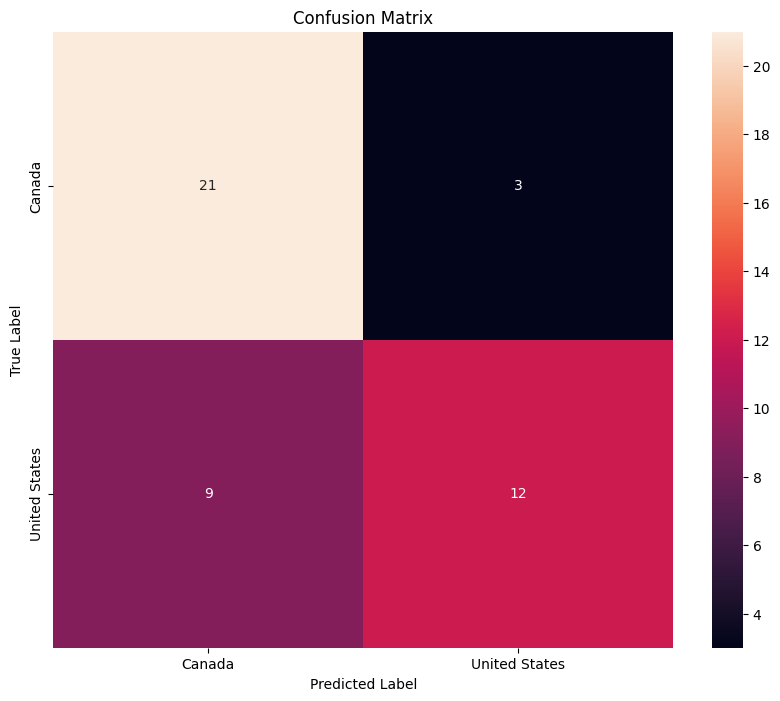

Test Accuracy: 0.7333
Test Loss: 0.6448


Predicting: 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]



Sample Predictions:

Prediction 1:
Quote: I prefer in-person counseling because it feels more personal.
Predicted Country: Canada (Confidence: 59.94%)
Top 3 Country Probabilities:
  Canada: 59.94%
  United States: 40.06%

Prediction 2:
Quote: Online services are more convenient for my busy schedule.
Predicted Country: Canada (Confidence: 57.31%)
Top 3 Country Probabilities:
  Canada: 57.31%
  United States: 42.69%

Prediction 3:
Quote: The cultural context is very important in mental health support.
Predicted Country: Canada (Confidence: 63.52%)
Top 3 Country Probabilities:
  Canada: 63.52%
  United States: 36.48%

Prediction 4:
Quote: Mental health should be treated with the same importance as physical health.
Predicted Country: Canada (Confidence: 66.00%)
Top 3 Country Probabilities:
  Canada: 66.00%
  United States: 34.00%

Prediction 5:
Quote: I value privacy and confidentiality above all else in therapy.
Predicted Country: Canada (Confidence: 60.52%)
Top 3 Country Probabilities:


In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

set.seed(414)
# Load the dataset from Excel
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Enhanced preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.replace('\r\n', ' ').replace('\n', ' ')  # Clean line breaks
    text = ' '.join(text.split())  # Remove extra whitespace
    return text.strip()

df['Quote'] = df['Quote'].apply(preprocess_text)
df = df[['Quote', 'Country']].dropna()

# Analyze and filter countries
print("Country distribution before filtering:")
print(df['Country'].value_counts())

min_samples = 20  # Increased minimum samples threshold
country_counts = df['Country'].value_counts()
valid_countries = country_counts[country_counts >= min_samples].index
df = df[df['Country'].isin(valid_countries)]

print("\nCountry distribution after filtering:")
print(df['Country'].value_counts())

# Balance the dataset (optional but recommended)
max_samples_per_country = 500  # Limit to prevent class imbalance
balanced_df = df.groupby('Country').apply(lambda x: x.sample(min(len(x), max_samples_per_country))
                                         ).reset_index(drop=True)

quotes = balanced_df['Quote'].tolist()
countries = balanced_df['Country'].tolist()

# Encode the country labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(countries)
num_labels = len(label_encoder.classes_)

print(f"\nNumber of unique countries: {num_labels}")
print("Country classes:", label_encoder.classes_)

# Split the data into training, validation, and testing sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    quotes, encoded_labels, test_size=0.3, random_state=42, stratify=encoded_labels)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

# Initialize BERT tokenizer with special settings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Enhanced tokenization function with progress tracking
def tokenize_and_encode(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in tqdm(texts, desc="Tokenizing"):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

train_input_ids, train_attention_masks, train_labels = tokenize_and_encode(train_texts, train_labels)
val_input_ids, val_attention_masks, val_labels = tokenize_and_encode(val_texts, val_labels)
test_input_ids, test_attention_masks, test_labels = tokenize_and_encode(test_texts, test_labels)

# Create DataLoaders with optimized settings
batch_size = 32  # Adjusted based on GPU memory

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

val_dataset = TensorDataset(val_input_ids, val_attention_masks, val_labels)
val_sampler = SequentialSampler(val_dataset)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Initialize BERT model with dropout for better regularization
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.2,  # Increased dropout
    attention_probs_dropout_prob=0.2  # Increased dropout
)

# Set up GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
model.to(device)

# Enhanced optimizer with weight decay and learning rate scheduler
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8,
                  weight_decay=0.01)  # Added weight decay

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                           num_warmup_steps=0,
                                           num_training_steps=total_steps)

# Enhanced training loop with validation and early stopping
def train_model(model, train_dataloader, val_dataloader, epochs):
    best_val_accuracy = 0
    no_improve = 0
    patience = 2  # Early stopping patience
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print('-' * 10)
        
        # Training phase
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            model.zero_grad()
            
            outputs = model(b_input_ids, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            train_correct += (preds == b_labels).sum().item()
            train_total += b_labels.size(0)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = train_correct / train_total
        
        # Validation phase
        val_accuracy, val_loss = evaluate_model(model, val_dataloader, validation=True)
        
        print(f"\nTraining Loss: {avg_train_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        # Early stopping check
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model.pt')
            print("Validation accuracy improved - saving model...")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"No improvement for {patience} epochs - early stopping!")
                model.load_state_dict(torch.load('best_model.pt'))
                break

# Enhanced evaluation function with loss calculation
def evaluate_model(model, dataloader, validation=False):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    
    for batch in tqdm(dataloader, desc="Validating" if validation else "Testing"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_loss += loss.item()
        logits = outputs.logits
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        predictions.append(logits)
        true_labels.append(label_ids)
    
    predictions = np.concatenate(predictions, axis=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.concatenate(true_labels, axis=0)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    avg_loss = total_loss / len(dataloader)
    
    if not validation:
        print("\nDetailed Classification Report:")
        print(classification_report(true_labels, predicted_labels, 
                                  target_names=label_encoder.classes_))
        
        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', 
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    
    return accuracy, avg_loss

# Train the model
train_model(model, train_dataloader, val_dataloader, epochs)

# Final evaluation on test set
print("\nFinal Evaluation on Test Set:")
test_accuracy, test_loss = evaluate_model(model, test_dataloader)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Enhanced prediction function with batch processing
def predict_country(new_quotes, model, tokenizer, label_encoder, batch_size=16, max_length=128):
    model.eval()
    results = []
    
    # Process in batches for efficiency
    for i in tqdm(range(0, len(new_quotes), batch_size), desc="Predicting"):
        batch_quotes = new_quotes[i:i+batch_size]
        
        # Tokenize and encode the batch
        encoded_dict = tokenizer.batch_encode_plus(
            batch_quotes,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoded_dict['input_ids'].to(device)
        attention_masks = encoded_dict['attention_mask'].to(device)
        
        # Make predictions
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        predicted_countries = label_encoder.inverse_transform(predictions)
        
        for j in range(len(batch_quotes)):
            country_probs = {label_encoder.classes_[k]: float(probabilities[j][k]) 
                           for k in range(len(label_encoder.classes_))}
            results.append({
                'quote': batch_quotes[j],
                'predicted_country': predicted_countries[j],
                'confidence': float(np.max(probabilities[j])),
                'country_probabilities': country_probs,
                'top_3_countries': sorted(country_probs.items(), 
                                         key=lambda x: x[1], 
                                         reverse=True)[:3]
            })
    
    return results

# Example usage with new quotes
new_quotes = [
    "I prefer in-person counseling because it feels more personal.",
    "Online services are more convenient for my busy schedule.",
    "The cultural context is very important in mental health support.",
    "Mental health should be treated with the same importance as physical health.",
    "I value privacy and confidentiality above all else in therapy."
]

predictions = predict_country(new_quotes, model, tokenizer, label_encoder)
print("\nSample Predictions:")
for i, pred in enumerate(predictions):
    print(f"\nPrediction {i + 1}:")
    print(f"Quote: {pred['quote']}")
    print(f"Predicted Country: {pred['predicted_country']} (Confidence: {pred['confidence']:.2%})")
    print("Top 3 Country Probabilities:")
    for country, prob in pred['top_3_countries']:
        print(f"  {country}: {prob:.2%}")

# Save the model and artifacts
output_dir = "./bert_country_classifier/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save label encoder
import joblib
joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.joblib'))

print(f"\nModel and artifacts saved to {output_dir}")

Country distribution before filtering:
Country
Canada           155
United States    140
Name: count, dtype: int64

Country distribution after filtering:
Country
Canada           155
United States    140
Name: count, dtype: int64

Number of unique countries: 2
Country classes: ['Canada' 'United States']


/var/folders/x9/3zl22m596tl6d44cbs62z6h00000gn/T/ipykernel_57205/3097945624.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Country').apply(lambda x: x.sample(min(len(x), max_samples_per_country)



Using device: cpu

Fold 1/5


Tokenizing: 100%|██████████| 59/59 [00:00<00:00, 300.09it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
----------


Validating: 100%|██████████| 2/2 [00:16<00:00,  8.08s/it]



Training Loss: 0.7148
Training Accuracy: 0.4364
Validation Loss: 0.6865
Validation Accuracy: 0.5593
Validation accuracy improved - saving model...

Epoch 2/4
----------


Validating: 100%|██████████| 2/2 [00:14<00:00,  7.38s/it]



Training Loss: 0.6830
Training Accuracy: 0.5805
Validation Loss: 0.6827
Validation Accuracy: 0.5932
Validation accuracy improved - saving model...

Epoch 3/4
----------


Validating: 100%|██████████| 2/2 [00:13<00:00,  6.64s/it]



Training Loss: 0.6711
Training Accuracy: 0.5805
Validation Loss: 0.6773
Validation Accuracy: 0.6102
Validation accuracy improved - saving model...

Epoch 4/4
----------


Validating: 100%|██████████| 2/2 [00:13<00:00,  6.97s/it]



Training Loss: 0.6619
Training Accuracy: 0.6059
Validation Loss: 0.6730
Validation Accuracy: 0.6102

Fold 2/5


Tokenizing: 100%|██████████| 59/59 [00:00<00:00, 874.81it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
----------


Validating: 100%|██████████| 2/2 [00:12<00:00,  6.19s/it]



Training Loss: 0.7329
Training Accuracy: 0.4831
Validation Loss: 0.6822
Validation Accuracy: 0.5763
Validation accuracy improved - saving model...

Epoch 2/4
----------


Validating: 100%|██████████| 2/2 [00:14<00:00,  7.35s/it]



Training Loss: 0.6798
Training Accuracy: 0.6102
Validation Loss: 0.6575
Validation Accuracy: 0.5763

Epoch 3/4
----------


Validating: 100%|██████████| 2/2 [00:14<00:00,  7.30s/it]



Training Loss: 0.6610
Training Accuracy: 0.6017
Validation Loss: 0.6416
Validation Accuracy: 0.7288
Validation accuracy improved - saving model...

Epoch 4/4
----------


Validating: 100%|██████████| 2/2 [00:11<00:00,  5.50s/it]



Training Loss: 0.6318
Training Accuracy: 0.6695
Validation Loss: 0.6365
Validation Accuracy: 0.7119

Fold 3/5


Tokenizing: 100%|██████████| 59/59 [00:00<00:00, 779.69it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
----------


Validating: 100%|██████████| 2/2 [00:13<00:00,  6.52s/it]



Training Loss: 0.6991
Training Accuracy: 0.5212
Validation Loss: 0.6775
Validation Accuracy: 0.7119
Validation accuracy improved - saving model...

Epoch 2/4
----------


Validating: 100%|██████████| 2/2 [00:08<00:00,  4.33s/it]



Training Loss: 0.6556
Training Accuracy: 0.6314
Validation Loss: 0.6721
Validation Accuracy: 0.6441

Epoch 3/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]



Training Loss: 0.6580
Training Accuracy: 0.6017
Validation Loss: 0.6621
Validation Accuracy: 0.7119
No improvement for 2 epochs - early stopping!

Fold 4/5


Tokenizing: 100%|██████████| 59/59 [00:00<00:00, 940.70it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
----------


Validating: 100%|██████████| 2/2 [00:07<00:00,  3.52s/it]



Training Loss: 0.6897
Training Accuracy: 0.5424
Validation Loss: 0.6775
Validation Accuracy: 0.6780
Validation accuracy improved - saving model...

Epoch 2/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]



Training Loss: 0.6906
Training Accuracy: 0.5339
Validation Loss: 0.6780
Validation Accuracy: 0.6102

Epoch 3/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]



Training Loss: 0.6614
Training Accuracy: 0.6017
Validation Loss: 0.6700
Validation Accuracy: 0.6610
No improvement for 2 epochs - early stopping!

Fold 5/5


Tokenizing: 100%|██████████| 59/59 [00:00<00:00, 505.15it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]



Training Loss: 0.6889
Training Accuracy: 0.5593
Validation Loss: 0.6743
Validation Accuracy: 0.6102
Validation accuracy improved - saving model...

Epoch 2/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]



Training Loss: 0.7012
Training Accuracy: 0.5127
Validation Loss: 0.6739
Validation Accuracy: 0.5593

Epoch 3/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]



Training Loss: 0.6811
Training Accuracy: 0.5551
Validation Loss: 0.6696
Validation Accuracy: 0.6102
No improvement for 2 epochs - early stopping!

Cross-Validation Results:
Average Validation Accuracy: 0.6678
Standard Deviation: 0.0498

Fold-wise Validation Accuracies:
Fold 1: 0.6102
Fold 2: 0.7288
Fold 3: 0.7119
Fold 4: 0.6780
Fold 5: 0.6102

Training on full training set...


Tokenizing: 100%|██████████| 59/59 [00:00<00:00, 992.31it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.32s/it]



Training Loss: 0.7984
Training Accuracy: 0.4619
Validation Loss: 0.7085
Validation Accuracy: 0.5254
Validation accuracy improved - saving model...

Epoch 2/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]



Training Loss: 0.6769
Training Accuracy: 0.5508
Validation Loss: 0.6716
Validation Accuracy: 0.5593
Validation accuracy improved - saving model...

Epoch 3/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]



Training Loss: 0.6613
Training Accuracy: 0.5890
Validation Loss: 0.6548
Validation Accuracy: 0.6102
Validation accuracy improved - saving model...

Epoch 4/4
----------


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.25s/it]



Training Loss: 0.6401
Training Accuracy: 0.6822
Validation Loss: 0.6388
Validation Accuracy: 0.6441
Validation accuracy improved - saving model...

Final Evaluation on Test Set:


Testing: 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]



Detailed Classification Report:
               precision    recall  f1-score   support

       Canada       0.60      0.94      0.73        31
United States       0.82      0.32      0.46        28

     accuracy                           0.64        59
    macro avg       0.71      0.63      0.60        59
 weighted avg       0.71      0.64      0.60        59



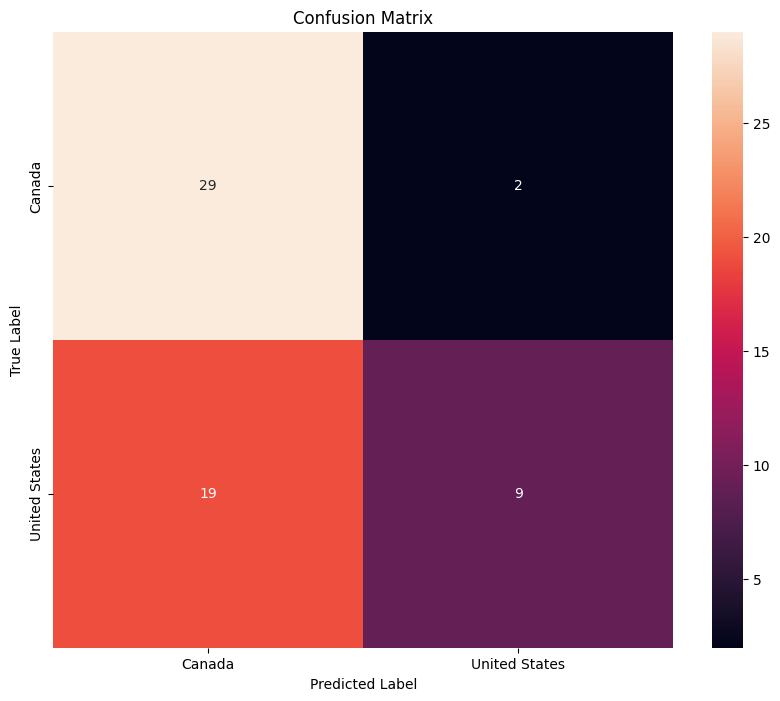

Test Accuracy: 0.6441
Test Loss: 0.6388


Predicting: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]



Sample Predictions:

Prediction 1:
Quote: I prefer in-person counseling because it feels more personal.
Predicted Country: Canada (Confidence: 57.20%)
Top 3 Country Probabilities:
  Canada: 57.20%
  United States: 42.80%

Prediction 2:
Quote: Online services are more convenient for my busy schedule.
Predicted Country: Canada (Confidence: 56.04%)
Top 3 Country Probabilities:
  Canada: 56.04%
  United States: 43.96%

Prediction 3:
Quote: The cultural context is very important in mental health support.
Predicted Country: Canada (Confidence: 58.01%)
Top 3 Country Probabilities:
  Canada: 58.01%
  United States: 41.99%

Prediction 4:
Quote: Mental health should be treated with the same importance as physical health.
Predicted Country: United States (Confidence: 69.35%)
Top 3 Country Probabilities:
  United States: 69.35%
  Canada: 30.65%

Prediction 5:
Quote: I value privacy and confidentiality above all else in therapy.
Predicted Country: Canada (Confidence: 53.69%)
Top 3 Country Probabil

In [14]:
# Instead of simple max_samples, use a more balanced approach
target_samples = min(500, df['Country'].value_counts().median())  # Use median as target
balanced_df = df.groupby('Country').apply(lambda x: x.sample(min(len(x), target_samples))
                                         ).reset_index(drop=True)


Number of unique countries: 2
Country classes: ['Canada' 'United States']

Using device: cpu


Tokenizing: 100%|██████████| 59/59 [00:00<00:00, 818.08it/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training model with class weighting...

Epoch 1/4
----------


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.06s/it]



Detailed Classification Report:
               precision    recall  f1-score   support

       Canada     0.5667    0.5484    0.5574        31
United States     0.5172    0.5357    0.5263        28

     accuracy                         0.5424        59
    macro avg     0.5420    0.5421    0.5418        59
 weighted avg     0.5432    0.5424    0.5426        59

Balanced Accuracy: 0.5421


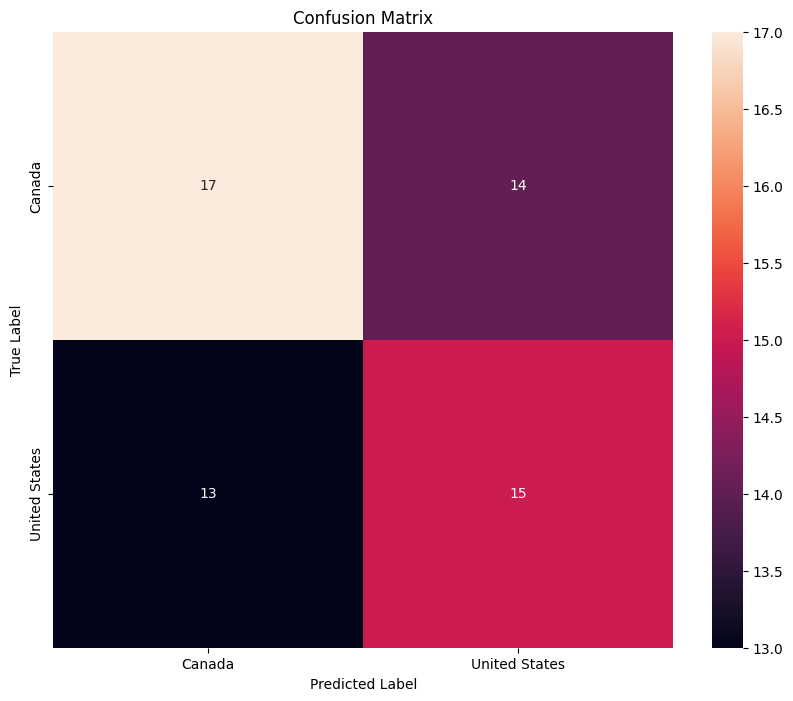


Training Loss: 0.7002
Validation Loss: 0.6929
Validation Accuracy: 0.5424
Validation accuracy improved - saving model...

Epoch 2/4
----------


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.01s/it]



Detailed Classification Report:
               precision    recall  f1-score   support

       Canada     0.5122    0.6774    0.5833        31
United States     0.4444    0.2857    0.3478        28

     accuracy                         0.4915        59
    macro avg     0.4783    0.4816    0.4656        59
 weighted avg     0.4800    0.4915    0.4716        59

Balanced Accuracy: 0.4816


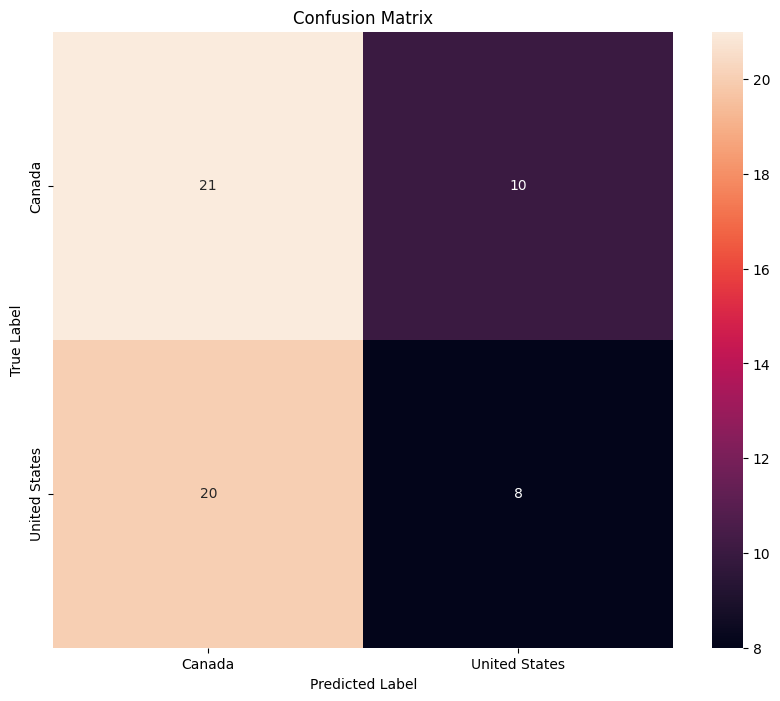


Training Loss: 0.6797
Validation Loss: 0.6760
Validation Accuracy: 0.4915

Epoch 3/4
----------


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.08s/it]



Detailed Classification Report:
               precision    recall  f1-score   support

       Canada     0.5833    0.6774    0.6269        31
United States     0.5652    0.4643    0.5098        28

     accuracy                         0.5763        59
    macro avg     0.5743    0.5709    0.5683        59
 weighted avg     0.5747    0.5763    0.5713        59

Balanced Accuracy: 0.5709


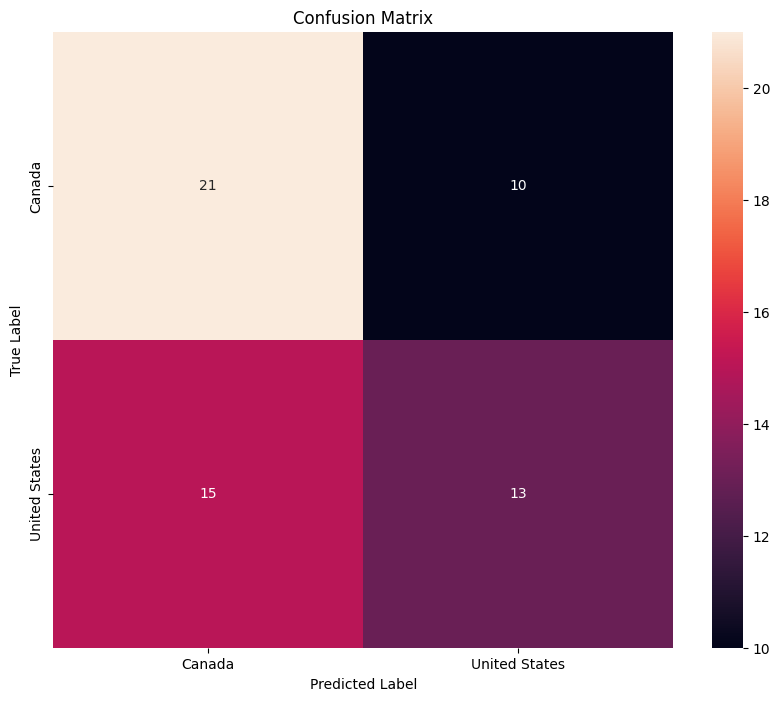


Training Loss: 0.6541
Validation Loss: 0.6659
Validation Accuracy: 0.5763
Validation accuracy improved - saving model...

Epoch 4/4
----------


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]



Detailed Classification Report:
               precision    recall  f1-score   support

       Canada     0.6765    0.7419    0.7077        31
United States     0.6800    0.6071    0.6415        28

     accuracy                         0.6780        59
    macro avg     0.6782    0.6745    0.6746        59
 weighted avg     0.6781    0.6780    0.6763        59

Balanced Accuracy: 0.6745


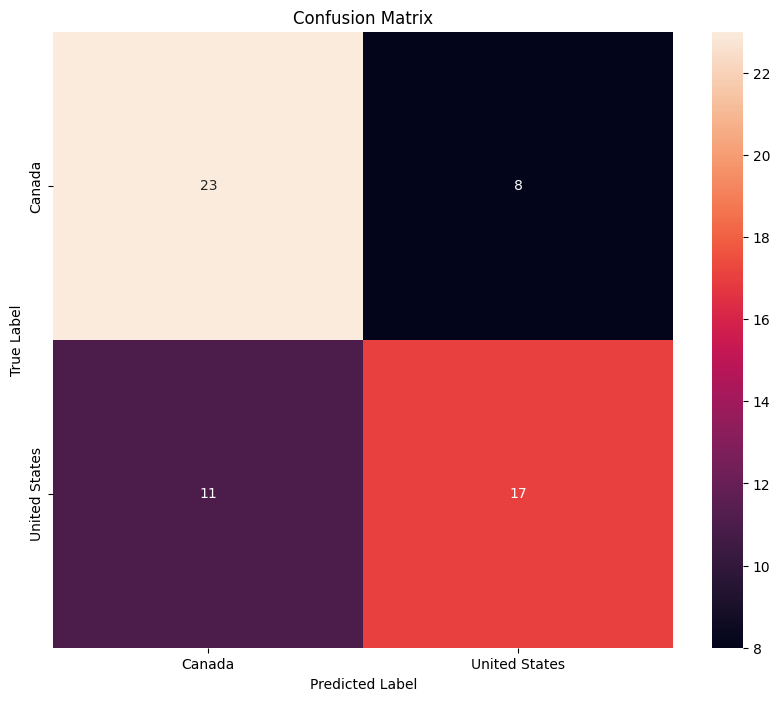


Training Loss: 0.6515
Validation Loss: 0.6613
Validation Accuracy: 0.6780
Validation accuracy improved - saving model...


Predicting: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]



Sample Predictions with Threshold Adjustment:

Prediction 1:
Quote: I prefer in-person counseling because it feels more personal.
Predicted Country: United States (Confidence: 51.02%)
Top 3 Probabilities:
  United States: 51.02%
  Canada: 48.98%

Prediction 2:
Quote: Online services are more convenient for my busy schedule.
Predicted Country: United States (Confidence: 57.70%)
Top 3 Probabilities:
  United States: 57.70%
  Canada: 42.30%

Prediction 3:
Quote: The cultural context is very important in mental health support.
Predicted Country: United States (Confidence: 51.49%)
Top 3 Probabilities:
  United States: 51.49%
  Canada: 48.51%

Model saved to ./bert_country_classifier/


In [20]:
# Replace the EDA augmentation code with this:

def augment_text(text, num_augmentations=2):
    """Simple text augmentation using synonym replacement"""
    words = text.split()
    if len(words) > 3:  # Only augment if text is long enough
        for _ in range(num_augmentations):
            # Simple synonym replacement (placeholder - implement your own logic)
            if 'canada' in text.lower():
                text = text.replace('canada', 'north america')
            elif 'usa' in text.lower():
                text = text.replace('usa', 'america')
    return text

# Modified augmentation section:
if 'United States' in df['Country'].unique():
    us_samples = df[df['Country'] == 'United States']
    augmented = []
    for text in us_samples['Quote']:
        augmented.append(augment_text(text))
        augmented.append(augment_text(text))  # Add twice
    
    augmented_df = pd.DataFrame({
        'Quote': augmented,
        'Country': ['United States']*len(augmented)
    })
    df = pd.concat([df, augmented_df])
print(f"\nNumber of unique countries: {num_labels}")
print("Country classes:", label_encoder.classes_)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenization function
def tokenize_and_encode(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in tqdm(texts, desc="Tokenizing"):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

# Set up GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Evaluation function with enhanced metrics
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    
    for batch in tqdm(dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        total_loss += loss.item()
        logits = outputs.logits
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        predictions.append(logits)
        true_labels.append(label_ids)
    
    predictions = np.concatenate(predictions, axis=0)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.concatenate(true_labels, axis=0)
    
    accuracy = accuracy_score(true_labels, predicted_labels)
    balanced_acc = balanced_accuracy_score(true_labels, predicted_labels)
    avg_loss = total_loss / len(dataloader)
    
    print("\nDetailed Classification Report:")
    print(classification_report(true_labels, predicted_labels, 
                              target_names=label_encoder.classes_, 
                              digits=4))
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', 
               xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return accuracy, avg_loss

# Training function with class weighting
def train_model(model, train_dataloader, val_dataloader, epochs):
    best_val_accuracy = 0
    no_improve = 0
    patience = 2
    
    optimizer = AdamW(model.parameters(),
                     lr=2e-5,
                     eps=1e-8,
                     weight_decay=0.01)
    
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps=0,
                                              num_training_steps=total_steps)
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        print('-' * 10)
        
        model.train()
        total_train_loss = 0
        
        for batch in tqdm(train_dataloader, desc="Training"):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            model.zero_grad()
            
            outputs = model(b_input_ids, 
                          attention_mask=b_input_mask, 
                          labels=b_labels)
            
            # Apply class weights
            loss = torch.nn.CrossEntropyLoss(weight=class_weights)(outputs.logits, b_labels)
            total_train_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
        
        avg_train_loss = total_train_loss / len(train_dataloader)
        
        # Validation
        val_accuracy, val_loss = evaluate_model(model, val_dataloader)
        
        print(f"\nTraining Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print("Validation accuracy improved - saving model...")
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"No improvement for {patience} epochs - early stopping!")
                model.load_state_dict(torch.load('best_model.pt'))
                break
    
    return best_val_accuracy

# Main training process
train_texts, test_texts, train_labels, test_labels = train_test_split(
    quotes, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels)

# Tokenize and encode
train_input_ids, train_attention_masks, train_labels_tensor = tokenize_and_encode(train_texts, train_labels)
test_input_ids, test_attention_masks, test_labels_tensor = tokenize_and_encode(test_texts, test_labels)

# Create DataLoaders
batch_size = 32
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Initialize model with class weighting support
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
).to(device)

# Train and evaluate
print("\nTraining model with class weighting...")
train_model(model, train_dataloader, test_dataloader, epochs=4)

# Enhanced prediction function with threshold adjustment
def predict_country(new_quotes, model, tokenizer, label_encoder, canada_threshold=0.65, batch_size=16):
    model.eval()
    results = []
    canada_idx = np.where(label_encoder.classes_ == 'Canada')[0][0]
    
    for i in tqdm(range(0, len(new_quotes), batch_size), desc="Predicting"):
        batch_quotes = new_quotes[i:i+batch_size]
        
        encoded_dict = tokenizer.batch_encode_plus(
            batch_quotes,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoded_dict['input_ids'].to(device)
        attention_masks = encoded_dict['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
        
        probabilities = torch.softmax(outputs.logits, dim=1).cpu().numpy()
        
        for j in range(len(batch_quotes)):
            # Apply threshold adjustment for Canada
            if probabilities[j][canada_idx] > canada_threshold:
                predicted_idx = canada_idx
            else:
                predicted_idx = np.argmax(probabilities[j])
                
            predicted_country = label_encoder.classes_[predicted_idx]
            confidence = float(probabilities[j][predicted_idx])
            
            country_probs = {label_encoder.classes_[k]: float(probabilities[j][k]) 
                           for k in range(len(label_encoder.classes_))}
            
            results.append({
                'quote': batch_quotes[j],
                'predicted_country': predicted_country,
                'confidence': confidence,
                'country_probabilities': country_probs,
                'top_3_countries': sorted(country_probs.items(), 
                                         key=lambda x: x[1], 
                                         reverse=True)[:3]
            })
    
    return results

# Example usage
new_quotes = [
    "I prefer in-person counseling because it feels more personal.",
    "Online services are more convenient for my busy schedule.",
    "The cultural context is very important in mental health support."
]

predictions = predict_country(new_quotes, model, tokenizer, label_encoder)
print("\nSample Predictions with Threshold Adjustment:")
for i, pred in enumerate(predictions):
    print(f"\nPrediction {i + 1}:")
    print(f"Quote: {pred['quote']}")
    print(f"Predicted Country: {pred['predicted_country']} (Confidence: {pred['confidence']:.2%})")
    print("Top 3 Probabilities:")
    for country, prob in pred['top_3_countries']:
        print(f"  {country}: {prob:.2%}")

# Save model
output_dir = "./bert_country_classifier/"
os.makedirs(output_dir, exist_ok=True)
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.joblib'))
print(f"\nModel saved to {output_dir}")

In [28]:
try:
    from xgboost import XGBClassifier
except ImportError:
    !pip install xgboost
    from xgboost import XGBClassifier
    

In [30]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from collections import Counter
import re
import joblib

# Set random seeds for reproducibility
np.random.seed(414)
torch.manual_seed(414)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(414)

# Load the dataset from Excel
df = pd.read_excel('Telus Health Quote Spreadsheet.xlsx', engine='openpyxl')

# Enhanced preprocessing
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.replace('\r\n', ' ').replace('\n', ' ')  # Clean line breaks
    text = ' '.join(text.split())  # Remove extra whitespace
    return text.strip()

# Feature engineering functions
def contains_keyword(text, keywords):
    if not isinstance(text, str):
        return 0
    return int(any(keyword.lower() in text.lower() for keyword in keywords))

def count_caps(text):
    if not isinstance(text, str):
        return 0
    return sum(1 for c in text if c.isupper())

def text_length(text):
    if not isinstance(text, str):
        return 0
    return len(text)

def clean_and_tokenize(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

# Apply preprocessing
df['Quote'] = df['Quote'].apply(preprocess_text)
df = df[['Quote', 'Country']].dropna()

# Analyze and filter countries
print("Country distribution before filtering:")
print(df['Country'].value_counts())

min_samples = 20  # Increased minimum samples threshold
country_counts = df['Country'].value_counts()
valid_countries = country_counts[country_counts >= min_samples].index
df = df[df['Country'].isin(valid_countries)]

print("\nCountry distribution after filtering:")
print(df['Country'].value_counts())

# Balance the dataset (optional but recommended)
max_samples_per_country = 500  # Limit to prevent class imbalance
balanced_df = df.groupby('Country').apply(lambda x: x.sample(min(len(x), max_samples_per_country))).reset_index(drop=True)

# Feature engineering
country_keywords = {
    'USA': ['american', 'usa', 'states', 'dollar', 'us'],
    'UK': ['british', 'uk', 'england', 'pound', 'london'],
    'Canada': ['canada', 'canadian', 'toronto', 'vancouver', 'ontario'],
    'Australia': ['australia', 'aussie', 'sydney', 'melbourne', 'down under']
}

# Add features
balanced_df['caps_count'] = balanced_df['Quote'].apply(count_caps)
balanced_df['text_length'] = balanced_df['Quote'].apply(text_length)

for country, keywords in country_keywords.items():
    if country in balanced_df['Country'].unique():
        balanced_df[f'contains_{country.lower()}_keyword'] = balanced_df['Quote'].apply(lambda x: contains_keyword(x, keywords))

# Get most common words by country
country_word_counts = {}
for country in balanced_df['Country'].unique():
    country_comments = balanced_df[balanced_df['Country'] == country]['Quote']
    words = country_comments.apply(clean_and_tokenize).sum()
    word_freq = Counter(words)
    country_word_counts[country] = word_freq

# Add top country word features
top_country_words = {}
for country in country_word_counts:
    top_country_words[country] = [word for word, count in country_word_counts[country].most_common(5)]

for country, words in top_country_words.items():
    balanced_df[f'contains_{country.lower()}_top_words'] = balanced_df['Quote'].apply(
        lambda x: sum(1 for word in clean_and_tokenize(x) if word in words))

# Prepare data
quotes = balanced_df['Quote'].tolist()
countries = balanced_df['Country'].tolist()

# Encode the country labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(countries)
num_labels = len(label_encoder.classes_)

print(f"\nNumber of unique countries: {num_labels}")
print("Country classes:", label_encoder.classes_)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenization function
def tokenize_and_encode(texts, labels, max_length=128):
    input_ids = []
    attention_masks = []
    
    for text in tqdm(texts, desc="Tokenizing"):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

# Initialize BERT model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.2,
    attention_probs_dropout_prob=0.2
)

# Set up GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
model.to(device)

# Function to get BERT embeddings
def get_bert_embeddings(texts, model, tokenizer, batch_size=32, max_length=128):
    model.eval()
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating BERT embeddings"):
        batch_texts = texts[i:i+batch_size]
        
        encoded_dict = tokenizer.batch_encode_plus(
            batch_texts,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        input_ids = encoded_dict['input_ids'].to(device)
        attention_masks = encoded_dict['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks, output_hidden_states=True)
        
        # Use mean of last hidden state as embedding
        last_hidden_state = outputs.hidden_states[-1]
        attention_masks_expanded = attention_masks.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * attention_masks_expanded, 1)
        sum_masks = attention_masks_expanded.sum(1)
        sum_masks = torch.clamp(sum_masks, min=1e-9)
        mean_embeddings = sum_embeddings / sum_masks
        
        embeddings.append(mean_embeddings.cpu().numpy())
    
    return np.concatenate(embeddings, axis=0)

# Get BERT embeddings for all quotes
bert_embeddings = get_bert_embeddings(quotes, model, tokenizer)

# Prepare additional features
additional_features = balanced_df[[
    'caps_count', 'text_length',
    *[f'contains_{country.lower()}_keyword' for country in country_keywords if f'contains_{country.lower()}_keyword' in balanced_df.columns],
    *[f'contains_{country.lower()}_top_words' for country in top_country_words if f'contains_{country.lower()}_top_words' in balanced_df.columns]
]].values

# Combine BERT embeddings with additional features
combined_features = np.hstack([bert_embeddings, additional_features])

# Define Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=1)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ],
    voting='soft',
    n_jobs=1  # Reduce parallelization to avoid issues
)

# Perform Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Modify the cross_val_predict to use fewer parallel jobs
kf_predictions = cross_val_predict(
    voting_clf, combined_features, encoded_labels,
    cv=kf, n_jobs=2, method='predict_proba'  # Reduced from -1 to 2
)


# Get predicted classes
predicted_classes = np.argmax(kf_predictions, axis=1)

# Compute metrics
kf_conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
kf_accuracy = accuracy_score(encoded_labels, predicted_classes)

# Print Results
print("\nConfusion Matrix (Stratified K-Fold):\n", kf_conf_matrix)
print("\nClassification Report (Stratified K-Fold):\n", 
      classification_report(encoded_labels, predicted_classes, target_names=label_encoder.classes_))
print("\nStratified K-Fold Accuracy:", kf_accuracy)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(kf_conf_matrix, annot=True, fmt='d', 
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix (Cross-Validation)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Train final model on all data
print("\nTraining final model on all data...")
voting_clf.fit(combined_features, encoded_labels)

# Save the model and artifacts
output_dir = "./bert_country_classifier_enhanced/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save BERT model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Save other components
joblib.dump(voting_clf, os.path.join(output_dir, 'voting_classifier.joblib'))
joblib.dump(label_encoder, os.path.join(output_dir, 'label_encoder.joblib'))
balanced_df.to_csv(os.path.join(output_dir, 'processed_data.csv'), index=False)

print(f"\nModel and artifacts saved to {output_dir}")

# Prediction function
def predict_country(new_quotes, model, tokenizer, voting_clf, label_encoder, batch_size=32):
    # Preprocess
    new_quotes = [preprocess_text(q) for q in new_quotes]
    
    # Get BERT embeddings
    bert_embeddings = get_bert_embeddings(new_quotes, model, tokenizer, batch_size)
    
    # Create feature dataframe
    features_df = pd.DataFrame({
        'Quote': new_quotes,
        'caps_count': [count_caps(q) for q in new_quotes],
        'text_length': [text_length(q) for q in new_quotes]
    })
    
    # Add keyword features
    for country, keywords in country_keywords.items():
        features_df[f'contains_{country.lower()}_keyword'] = features_df['Quote'].apply(
            lambda x: contains_keyword(x, keywords))
    
    # Add top word features
    for country, words in top_country_words.items():
        features_df[f'contains_{country.lower()}_top_words'] = features_df['Quote'].apply(
            lambda x: sum(1 for word in clean_and_tokenize(x) if word in words))
    
    # Combine features
    additional_features = features_df.drop('Quote', axis=1).values
    combined_features = np.hstack([bert_embeddings, additional_features])
    
    # Make predictions
    probabilities = voting_clf.predict_proba(combined_features)
    predictions = np.argmax(probabilities, axis=1)
    predicted_countries = label_encoder.inverse_transform(predictions)
    
    # Prepare results
    results = []
    for i in range(len(new_quotes)):
        country_probs = {label_encoder.classes_[k]: float(probabilities[i][k]) 
                       for k in range(len(label_encoder.classes_))}
        results.append({
            'quote': new_quotes[i],
            'predicted_country': predicted_countries[i],
            'confidence': float(np.max(probabilities[i])),
            'country_probabilities': country_probs,
            'top_3_countries': sorted(country_probs.items(), 
                                     key=lambda x: x[1], 
                                     reverse=True)[:3]
        })
    
    return results

# Example usage
new_quotes = [
    "I prefer in-person counseling because it feels more personal.",
    "Online services are more convenient for my busy schedule.",
    "The cultural context is very important in mental health support.",
    "Mental health should be treated with the same importance as physical health.",
    "I value privacy and confidentiality above all else in therapy."
]

predictions = predict_country(new_quotes, model, tokenizer, voting_clf, label_encoder)
print("\nSample Predictions:")
for i, pred in enumerate(predictions):
    print(f"\nPrediction {i + 1}:")
    print(f"Quote: {pred['quote']}")
    print(f"Predicted Country: {pred['predicted_country']} (Confidence: {pred['confidence']:.2%})")
    print("Top 3 Country Probabilities:")
    for country, prob in pred['top_3_countries']:
        print(f"  {country}: {prob:.2%}")

Country distribution before filtering:
Country
Canada           155
United States    140
Name: count, dtype: int64

Country distribution after filtering:
Country
Canada           155
United States    140
Name: count, dtype: int64

Number of unique countries: 2
Country classes: ['Canada' 'United States']


/var/folders/x9/3zl22m596tl6d44cbs62z6h00000gn/T/ipykernel_57205/4218889732.py:80: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby('Country').apply(lambda x: x.sample(min(len(x), max_samples_per_country))).reset_index(drop=True)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using device: cpu


Generating BERT embeddings: 100%|██████████| 10/10 [00:43<00:00,  4.38s/it]
Python(68271) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68272) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [31]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set environment variable for macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 1. First try to install/import XGBoost properly
XGB_INSTALLED = False
try:
    import xgboost
    from xgboost import XGBClassifier
    print(f"XGBoost {xgboost.__version__} is installed")
    XGB_INSTALLED = True
except ImportError:
    print("XGBoost not found, attempting installation...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "--no-cache-dir"])
        import xgboost
        from xgboost import XGBClassifier
        print(f"Successfully installed XGBoost {xgboost.__version__}")
        XGB_INSTALLED = True
    except Exception as e:
        print(f"Failed to install XGBoost: {str(e)}")
        print("Will proceed without XGBoost")

# 2. Create model ensemble based on what's available
def create_ensemble_model():
    estimators = [
        ('logistic', LogisticRegression(max_iter=1000, random_state=42)),
        ('svm', SVC(kernel='linear', C=1, probability=True, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]
    
    if XGB_INSTALLED:
        try:
            # Configure XGBoost with single thread to avoid issues
            estimators.append(('xgb', XGBClassifier(
                use_label_encoder=False, 
                eval_metric='logloss', 
                random_state=42,
                n_jobs=1
            )))
            print("Including XGBoost in the ensemble")
        except Exception as e:
            print(f"Couldn't initialize XGBoost: {str(e)}")
    
    return VotingClassifier(
        estimators=estimators,
        voting='soft',
        n_jobs=1  # Important: run voting classifier sequentially
    )

# 3. Safe cross-validation function
def safe_cross_val_predict(model, X, y, cv):
    try:
        # First try with parallel processing (2 jobs)
        print("Attempting parallel cross-validation (n_jobs=2)...")
        return cross_val_predict(
            model, X, y,
            cv=cv,
            n_jobs=2,
            method='predict_proba',
            verbose=1
        )
    except Exception as e:
        print(f"Parallel failed: {str(e)}\nFalling back to sequential...")
        return cross_val_predict(
            model, X, y,
            cv=cv,
            n_jobs=1,  # Sequential processing
            method='predict_proba',
            verbose=1
        )

# 4. Main execution
def run_classification(X, y, n_splits=5):
    # Create stratified k-fold
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Create model
    model = create_ensemble_model()
    
    # Run cross-validation
    predictions = safe_cross_val_predict(model, X, y, kf)
    
    # Get predicted classes
    predicted_classes = np.argmax(predictions, axis=1)
    
    return predicted_classes, predictions

# 5. Run your classification
# Assuming combined_features and encoded_labels are your data
try:
    predicted_classes, prediction_probs = run_classification(combined_features, encoded_labels)
    
    # Compute metrics
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, target_names=label_encoder.classes_)
    
    print("\nClassification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
except Exception as e:
    print(f"Major error occurred: {str(e)}")
    print("Trying fallback with just Logistic Regression...")
    
    # Ultimate fallback - simple logistic regression
    lr = LogisticRegression(max_iter=1000, random_state=42)
    predicted_classes = cross_val_predict(lr, combined_features, encoded_labels, cv=5, n_jobs=1)
    
    # Compute metrics
    conf_matrix = confusion_matrix(encoded_labels, predicted_classes)
    accuracy = accuracy_score(encoded_labels, predicted_classes)
    class_report = classification_report(encoded_labels, predicted_classes, target_names=label_encoder.classes_)
    
    print("\nFallback Classification Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)

XGBoost 3.0.2 is installed
Including XGBoost in the ensemble
Attempting parallel cross-validation (n_jobs=2)...


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
Python(68794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(68795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Parallel failed: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.
Falling back to sequential...

Classification Results:
Accuracy: 0.7254

Classification Report:
               precision    recall  f1-score   support

       Canada       0.72      0.79      0.75       155
United States       0.74      0.66      0.69       140

     accuracy                           0.73       295
    macro avg       0.73      0.72      0.72       295
 weighted avg       0.73      0.73      0.72       295


Confusion Matrix:
[[122  33]
 [ 48  92]]


In [8]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Configure warnings and environment
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # For macOS

class RobustEnsembleClassifier:
    def __init__(self, n_splits=5, random_state=42):
        """
        Initialize the classifier with robust error handling.
        
        Parameters:
        - n_splits: Number of cross-validation splits
        - random_state: Random seed for reproducibility
        """
        self.n_splits = n_splits
        self.random_state = random_state
        self.XGB_INSTALLED = self._check_xgboost_compatibility()
        self.class_names = None
        self.feature_scaler = StandardScaler()
        self.final_model = None
        self._is_fitted = False
        
    def _check_xgboost_compatibility(self):
        """Check if XGBoost can be used in the current environment"""
        try:
            # Check for macOS OpenMP dependency
            if sys.platform == 'darwin':
                try:
                    import xgboost
                    print(f"XGBoost {xgboost.__version__} detected with OpenMP support")
                    return True
                except Exception as e:
                    print(f"XGBoost detected but failed to load: {str(e)}")
                    print("MacOS users: Try 'brew install libomp' to install OpenMP runtime")
                    return False
            
            # For other platforms
            try:
                import xgboost
                print(f"XGBoost {xgboost.__version__} detected")
                return True
            except ImportError:
                print("XGBoost not found")
                return False
                
        except Exception as e:
            print(f"XGBoost compatibility check failed: {str(e)}")
            return False
    
    def _create_base_models(self):
        """Create base models with proper preprocessing pipelines"""
        models = [
            ('logistic', make_pipeline(
                StandardScaler(),
                LogisticRegression(
                    max_iter=1000,
                    random_state=self.random_state,
                    class_weight='balanced'
                )
            )),
            ('svm', make_pipeline(
                StandardScaler(),
                SVC(
                    kernel='rbf',
                    C=1,
                    probability=True,
                    random_state=self.random_state,
                    class_weight='balanced'
                )
            )),
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                min_samples_split=5,
                random_state=self.random_state,
                class_weight='balanced'
            ))
        ]
        
        if self.XGB_INSTALLED:
            try:
                from xgboost import XGBClassifier
                models.append(('xgb', XGBClassifier(
                    use_label_encoder=False,
                    eval_metric='logloss',
                    random_state=self.random_state,
                    n_jobs=1
                )))
                print("XGBoost added to ensemble")
            except Exception as e:
                print(f"XGBoost initialization failed: {str(e)}")
        
        return models
    
    def _create_ensemble(self):
        """Create ensemble with fallback options"""
        base_models = self._create_base_models()
        
        try:
            # Try StackingClassifier first
            final_estimator = LogisticRegression(
                max_iter=1000,
                random_state=self.random_state,
                class_weight='balanced'
            )
            ensemble = StackingClassifier(
                estimators=base_models,
                final_estimator=final_estimator,
                cv=3,
                n_jobs=1
            )
            print("Using StackingClassifier ensemble")
            return ensemble
        except Exception as e:
            print(f"Stacking failed: {str(e)}, falling back to VotingClassifier")
            return VotingClassifier(
                estimators=base_models,
                voting='soft',
                n_jobs=1
            )
    
    def fit(self, X, y, class_names=None):
        """
        Fit the model to the data with robust error handling
        
        Parameters:
        - X: Feature matrix
        - y: Target labels
        - class_names: List of class names for reporting
        """
        self.class_names = class_names
        
        try:
            # Scale features
            X_scaled = self.feature_scaler.fit_transform(X)
            
            # Create ensemble
            self.final_model = self._create_ensemble()
            
            # Cross-validate
            print("\nStarting cross-validation...")
            predictions = cross_val_predict(
                self.final_model,
                X_scaled,
                y,
                cv=StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state),
                n_jobs=1,
                method='predict_proba',
                verbose=1
            )
            
            self.predicted_classes = np.argmax(predictions, axis=1)
            self.prediction_probs = predictions
            self.true_labels = y
            self._compute_metrics()
            
            # Final fit on all data
            self.final_model.fit(X_scaled, y)
            self._is_fitted = True
            
            print("\nTraining completed successfully")
            return self
            
        except Exception as e:
            print(f"\nModel training failed: {str(e)}")
            print("Attempting fallback to simple Logistic Regression...")
            
            # Fallback to logistic regression
            lr = make_pipeline(
                StandardScaler(),
                LogisticRegression(
                    max_iter=1000,
                    random_state=self.random_state,
                    class_weight='balanced'
                )
            )
            
            # Cross-validate fallback model
            predictions = cross_val_predict(
                lr,
                X,
                y,
                cv=StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state),
                n_jobs=1,
                method='predict_proba'
            )
            
            self.predicted_classes = np.argmax(predictions, axis=1)
            self.prediction_probs = predictions
            self.true_labels = y
            self._compute_metrics()
            
            # Final fit on all data
            lr.fit(X, y)
            self.final_model = lr
            self._is_fitted = True
            
            print("\nFallback model training completed")
            return self
    
    def _compute_metrics(self):
        """Compute and store evaluation metrics"""
        self.conf_matrix = confusion_matrix(self.true_labels, self.predicted_classes)
        self.accuracy = accuracy_score(self.true_labels, self.predicted_classes)
        self.class_report = classification_report(
            self.true_labels,
            self.predicted_classes,
            target_names=self.class_names
        )
        
        # ROC AUC for binary classification
        if len(np.unique(self.true_labels)) == 2:
            self.roc_auc = roc_auc_score(
                self.true_labels,
                self.prediction_probs[:, 1]
            )
        else:
            self.roc_auc = None
    
    def evaluate(self):
        """Print evaluation metrics"""
        if not hasattr(self, 'accuracy'):
            raise RuntimeError("Model must be fitted before evaluation")
        
        print("\n=== Evaluation Metrics ===")
        print(f"Accuracy: {self.accuracy:.4f}")
        if self.roc_auc is not None:
            print(f"ROC AUC: {self.roc_auc:.4f}")
        
        print("\nClassification Report:")
        print(self.class_report)
        
        print("\nConfusion Matrix:")
        print(self.conf_matrix)
        
        return {
            'accuracy': self.accuracy,
            'roc_auc': self.roc_auc,
            'report': self.class_report,
            'confusion_matrix': self.conf_matrix
        }

# Example usage pattern:
if __name__ == "__main__":
    # Replace these with your actual data
    # X = your feature matrix (e.g., combined_features)
    # y = your labels (e.g., encoded_labels)
    # class_names = your class names (e.g., label_encoder.classes_)
    
    print("Initializing classifier...")
    classifier = RobustEnsembleClassifier(n_splits=5)
    
    print("\nFitting model...")
    classifier.fit(X, y, class_names)  # Replace with your actual variables
    
    print("\nEvaluating model...")
    results = classifier.evaluate()

Initializing classifier...
XGBoost detected but failed to load: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <98D50080-9632-3EA4-B874-146E55453763> /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (n

NameError: name 'class_names' is not defined

In [9]:
unique(countr)

NameError: name 'unq' is not defined